In [1]:
#pip install apyori

- We are using the dataset from library arules in R. Libray rpy2 provides an interface to R programming

In [2]:
#pip install rpy2

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# enables the %%R magic
%load_ext rpy2.ipython

- We can run the R code in the cell below

In [5]:
%%R

library(arules)
data(Groceries) # Groceries object in arules
write(Groceries, file = "Groceries.csv", format="basket", sep = ",") # saving as a csv file

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: 'arules'


R[write to console]: The following objects are masked from 'package:base':

    abbreviate, write




In [6]:
# From here the python cells start again
import pandas as pd              
import matplotlib.pyplot as plt 
from apyori import apriori       # For Apriori algorithm

In [7]:
transactions = []

#To open the dataset and convert to list format for using in 'apriori()' function.
with open('./Groceries.csv') as f:
    for line in f:
        transaction = [item for item in line.strip().split(',') if item != 'NaN']
        transactions.append(transaction)
    
transactions[:3]

[['"citrus fruit"', '"semi-finished bread"', '"margarine"', '"ready soups"'],
 ['"tropical fruit"', '"yogurt"', '"coffee"'],
 ['"whole milk"']]

- Applying Apriori

In [8]:
rules = list(apriori(
    transactions, 
    min_support=0.001, 
    min_confidence=0.10,
    min_length=2,
    max_length=2))

# Print first rule
print(rules[0])

RelationRecord(items=frozenset({'"bottled water"'}), support=0.11052364006100661, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'"bottled water"'}), confidence=0.11052364006100661, lift=1.0)])


- Convert rules to readable format

In [9]:
rules_df = pd.DataFrame(
    [{'From': list(rule[0])[0],
    'To': list(rule[0])[1],
    'Support': rule[1],
    'Confidence': rule[2][0][2],
    'Lift': rule[2][0][3]} for rule in rules if len(rule[0]) == 2])
rules_df = rules_df.dropna()

rules_df.head()

,From,To,Support,Confidence,Lift
0,"""Instant food products""","""bottled water""",0.001017,0.126582,1.145296
1,"""Instant food products""","""butter""",0.001220,0.151899,2.741145
2,"""Instant food products""","""citrus fruit""",0.001118,0.139241,1.682347
3,"""Instant food products""","""curd""",0.001322,0.164557,3.088583
4,"""Instant food products""","""domestic eggs""",0.001017,0.126582,1.995091


- Listing rules based on frequency

In [10]:
# Pick top rules
rules_df = rules_df.sort_values('Support', ascending=False).head(50)

# List of all items
items = set(rules_df['From']) | set(rules_df['To'])

# Creates a mapping of items to numbers
imap = {item : i for i, item in enumerate(items)}

# Maps the items to numbers and adds the numeric 'FromN' and 'ToN' columns
rules_df['FromN'] = rules_df['From'].map(imap)
rules_df['ToN'] = rules_df['To'].map(imap)

# Displays the top 20 association rules, sorted by Support
rules_df.head(20)

,From,To,Support,Confidence,Lift,FromN,ToN
1539,"""whole milk""","""other vegetables""",0.074835,0.386758,1.513634,21,9
1744,"""whole milk""","""rolls/buns""",0.056634,0.307905,1.205032,21,3
1929,"""whole milk""","""yogurt""",0.056024,0.219260,1.571735,21,12
1769,"""whole milk""","""root vegetables""",0.048907,0.448694,1.756031,21,4
1506,"""root vegetables""","""other vegetables""",0.047382,0.244877,2.246605,4,9
1540,"""other vegetables""","""yogurt""",0.043416,0.224383,1.608457,9,12
1505,"""rolls/buns""","""other vegetables""",0.042603,0.220179,1.197047,3,9
1911,"""whole milk""","""tropical fruit""",0.042298,0.403101,1.577595,21,0
1864,"""whole milk""","""soda""",0.040061,0.229738,0.899112,21,20
1725,"""rolls/buns""","""soda""",0.038332,0.208402,1.195124,3,20


#### Plotting rules: 
- If a rule is A->B, then the item A is in the bottom row of the plot (y=0) and B is in the top row (y=1). 
- The color of each line indicates the support of the rule multiplied by 100 (support*100). 
- The width of each line is controlled by the confidence of each rule.

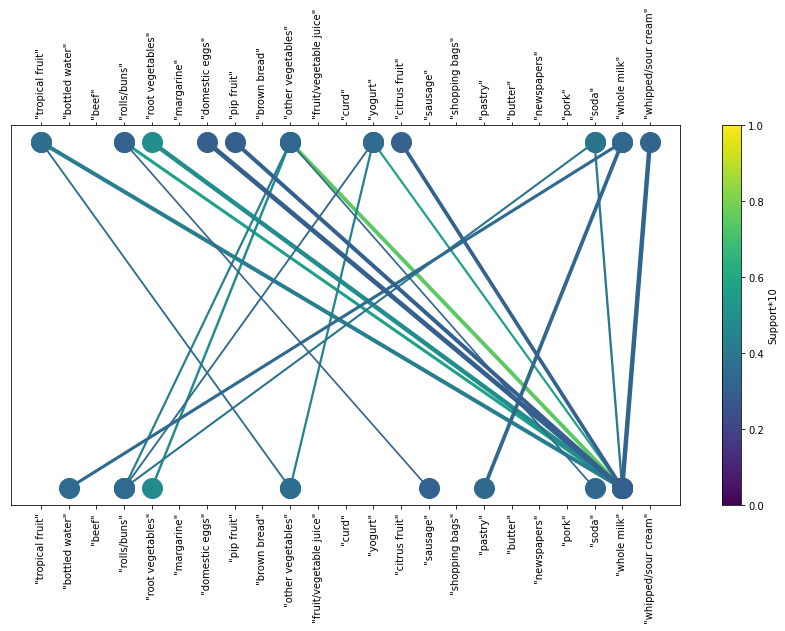

In [11]:
# Add ticks to the top of the graph also
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

# Set the size of the plot
fig = plt.figure(figsize=(15, 7))

# Draw a line between items for each rule
# Colors each line according to the support of the rule
for index, row in rules_df.head(20).iterrows():
    plt.plot([row['FromN'], row['ToN']], [0, 1], 'o-',
             c=plt.cm.viridis(row['Support'] * 10),
             markersize=20,
             lw=row['Confidence'] * 10)

# Add a colorbar and its title  
cb = plt.colorbar(plt.cm.ScalarMappable(cmap='viridis'))
cb.set_label('Support*10')

# Add labels to xticks and removes yticks
plt.xticks(range(len(items)), items, rotation='vertical')
plt.yticks([])
plt.show()